In this document, we have code to

* Translate code in the form of vcf written by the 1000 Genome people to the raw sequences
* Compare these sequences with reference sequences to create matrices of allele frequency 
* Run PCA analysis on these matrices


In [3]:
### Manual PCA Analysis
### BIOS 26211 Final Project
### Bruno Petrucci and Christian Porras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import allel
from sklearn.decomposition import PCA
import pandas as pd
from mpl_toolkits import mplot3d

Following is the code originally created to simulate some random sequences to test the rest of the code

In [4]:
### First create some Reference Sequence just to test the code
Nucleotides = ['A', 'T', 'C', 'G']
ReferenceSequence1 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
ReferenceSequence2 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
ReferenceSequence = np.append(ReferenceSequence1, ReferenceSequence2, axis=0)
# Of course it's unrealistic for both of them to be random but it's just for testing - this will be the reference

### Create some random sequence to compare
AnalysisSequence1 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
AnalysisSequence2 = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
AnalysisSequence = np.append(AnalysisSequence1, AnalysisSequence2, axis=0)

Here is the function that transforms sequences into matrices with 0, 1 and 2.

In [5]:
### Define the function that transforms the sequence into a PCA-ble matrix
def TransformSequence(Sequence, Reference):
    Transform = np.zeros(Sequence.shape[1])
    for i in range(Sequence.shape[1]):
        if (Sequence[0][i] == Reference[0][i] and Sequence[1][i] == Reference[1][i]) or (Sequence[0][i] == Reference[1][i] and Sequence[1][i] == Reference[0][i]):
            Transform[i] = 0
        elif Sequence[0][i] == Reference[0][i] or Sequence[1][i] == Reference[1][i] or Sequence[0][i] == Reference[1][i] or Sequence[1][i] == Reference[0][i]:
            Transform[i] = 1
        else:
            Transform[i] = 2
        
    return Transform

In [6]:
### Test for the sequences generated above
print(ReferenceSequence)
print(AnalysisSequence)
TransformedSequence = TransformSequence(AnalysisSequence, ReferenceSequence)
print(TransformedSequence)

[['A' 'A' 'A' 'C' 'C' 'C' 'C' 'A' 'T' 'C']
 ['A' 'T' 'T' 'T' 'A' 'C' 'C' 'T' 'C' 'T']]
[['T' 'T' 'C' 'G' 'T' 'C' 'T' 'A' 'A' 'A']
 ['C' 'A' 'A' 'T' 'G' 'G' 'C' 'G' 'T' 'C']]
[2. 0. 1. 1. 2. 1. 1. 1. 1. 1.]


In [7]:
### Generate a bunch of sequences to test the PCA analysis
SequencesGenerated = 10
Sequences = np.array([AnalysisSequence for i in range(SequencesGenerated)])

for i in range(1,SequencesGenerated):
    NewSequence = np.array([np.random.choice(Nucleotides, 10, p=[0.25, 0.25, 0.25, 0.25])])
    Sequences[:][:][i] = NewSequence

TransformedSequences = np.zeros((SequencesGenerated, Sequences.shape[2]))

for i in range(SequencesGenerated):
    TransformedSequences[i,:] = TransformSequence(Sequences[i,:,:], ReferenceSequence)

print(TransformedSequences)

[[2. 0. 1. 1. 2. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 0. 2. 1. 1. 1.]
 [0. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [0. 1. 1. 1. 2. 2. 2. 2. 1. 2.]
 [2. 2. 2. 2. 1. 2. 0. 1. 1. 1.]
 [2. 1. 2. 1. 2. 2. 2. 1. 1. 1.]
 [2. 1. 2. 2. 1. 2. 2. 2. 2. 2.]
 [2. 2. 2. 1. 2. 0. 0. 2. 2. 2.]
 [2. 2. 2. 1. 1. 0. 2. 2. 2. 2.]
 [0. 2. 2. 2. 1. 0. 2. 1. 1. 2.]]


Now we have the actual 1000 genome data, where we will translate and run PCA on

In [8]:
### Get the actual 1000 Genome 21st Chromosome data
callset = allel.read_vcf('ALL.chr21.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz')

In the callset we only have the genotype matrix, so we write code to transform it back into sequences

In [11]:
### Call the genotype matrix
GT = callset['calldata/GT']
GT1 = GT
print(GT.shape)

(1105538, 2504, 2)


In [12]:
Var = np.array(callset['variants/ALT'])
print(Var.shape)

(1105538, 3)


In [13]:
Ref = np.array(callset['variants/REF'])
print(Ref.shape)

(1105538,)


In [106]:
### Define a function to write a sequence from the allel data
def WriteSequence(Reference, Variations, GenMat):
    Sequence1  = np.array([np.repeat('A', len(Reference))])
    Sequence2  = np.array([np.repeat('A', len(Reference))])
    Sequence = np.append(Sequence1, Sequence2, axis = 0)
    
    for i in range(Sequence1.shape[0]):
        Options = np.array([Ref[i], Var[i, 0], Var[i, 1], Var[i, 2]])
        Sequence[:, i] = np.array([Options[int(GenMat[i, 0])], Options[int(GenMat[i, 1])]])
    return Sequence.T

In [11]:
### Write the sequences for the 1000 genome data
### Memory error if you try the full length
RawSequence1 = np.array([np.repeat('A', Ref.shape[0])])
RawSequence2 = np.array([np.repeat('A', Ref.shape[0])])
RawSequence = np.array([RawSequence1, RawSequence2]).T
RawSequenceTest = np.array([RawSequence1, RawSequence2]).T
for i in range(GT.shape[1]-1):
    RawSequence = np.append(RawSequence, RawSequenceTest, axis = 1)
print(RawSequence.shape)

for i in range(GT.shape[1]):
    Sequence = WriteSequence(Ref, Var, GT[:, i, :])
    RawSequence[:, i, :] = Sequence

KeyboardInterrupt: 

In [ ]:
print(RawSequence.shape)

In [14]:
### Here we transform the GT arrays into 0, 1 and 2 in light of the Novembre paper
GT1[GT1 == 2] = 1
GT1[GT1 == 3] = 1
ConvertedGT = np.sum(GT1, axis=2)
print(ConvertedGT.shape)

(1105538, 2504)


Now we need to extract the super populations from the data to color plots and plot subpopulations

In [15]:
key = pd.read_csv("20130606_g1k.ped", sep='\t')

In [16]:
key.head()

,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0


In [20]:
### Get indices of rows for our data in the key
key_id = key.iloc[:,1]
GT_id = callset["samples"]
idx = np.empty(len(GT_id))
for i in range(len(key_id)):
    for j in range(len(GT_id)):
        if key_id[i] == GT_id[j]:
            idx[j] = i

In [21]:
pops = key.iloc[idx,6] # populations for our chr21 data

In [22]:
super_pop = pd.read_csv("20131219.superpopulations.tsv", sep='\t')

In [23]:
super_pop

,Description,Population Code
0,East Asian,EAS
1,South Asian,SAS
2,African,AFR
3,European,EUR
4,American,AMR


In [24]:
pop_code = pd.read_csv("20131219.populations.tsv", sep='\t')

In [25]:
# Get indeces of 1000 genomes chr21 samples from key
uni_pops = []
for i in np.unique(pops):
    uni_pops += [np.where(pop_code.iloc[:,1]==i)[0][0]]

In [26]:
pop_arr = np.array(pops)

In [27]:
for i in range(len(np.unique(pops))):
    pop_arr[np.where(pops == np.unique(pops)[i])[0]] = np.array(pop_code.iloc[uni_pops,2])[i]

In [28]:
### Pull out indices by superpopulation
AFR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AFR")[0][0]])[0]
AMR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AMR")[0][0]])[0]
EAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EAS")[0][0]])[0]
EUR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EUR")[0][0]])[0]
SAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="SAS")[0][0]])[0]

In [31]:
samples = [AFR_idx,AMR_idx,EAS_idx,EUR_idx,SAS_idx]

In [33]:
pops_col = np.array(pops)

In [34]:
col_pal = np.arange(len(np.unique(pop_arr)))
for i in col_pal:
    pops_col[np.where(pop_arr == np.unique(pop_arr)[i])[0]] = col_pal[i]

Now we do a rudimentary linkage filtering before the PCA - we divide the GT rows into $1000$ pieces, and sample randomly from the inner $500$ of each piece

In [103]:
def SamplingSegments(Reference, Variants, GT, ConvertedGT, SegmentLength):
    NumSegments = int(ConvertedGT.shape[0]/SegmentLength)
    Remainder = ConvertedGT.shape[0] % NumSegments
    Indices = np.array([NumSegments*i for i in range(int(ConvertedGT.shape[0]/NumSegments)+1)])

    Samples = np.zeros((len(Indices), GT.shape[1], GT.shape[2]))
    ConvertedSamples = np.zeros((len(Indices), ConvertedGT.shape[1]))
    RefSegment = np.repeat('A', len(Indices))
    VarSegment =np.array([np.repeat('A', len(Indices)), np.repeat('A', len(Indices)), np.repeat('A', len(Indices))]).T
    ConvertedGTRows = range(ConvertedGT.shape[0])

    for i in range(Samples.shape[0]):
        if i != Samples.shape[0]-1:
            Row = np.random.choice(ConvertedGTRows[(Indices[i]+int(NumSegments/4)):(Indices[i+1]-int(NumSegments/4))], 1, p=np.repeat(1/int(NumSegments/2+1), int(NumSegments/2)+1))
            ConvertedSamples[i] = ConvertedGT[Row][:]
            Samples[i] = GT[Row][:][:]
            RefSegment[i] = Reference[Row][0]
            VarSegment[i] = Variants[Row]
        else:
            Row = np.random.choice(ConvertedGTRows[(Indices[i]+int(Remainder/4)):(ConvertedGT.shape[0]-int(Remainder/4))], 1, p=np.repeat(1/(Remainder/2+1), int(Remainder/2+1)))
            ConvertedSamples[i] = ConvertedGT[Row][:]
            Samples[i] = GT[Row][:][:]
            RefSegment[i] = Reference[Row][0]
            VarSegment[i] = Variants[Row]
    return RefSegment, VarSegment, Samples, ConvertedSamples

RefSegment, VarSegment, Samples, ConvertedSamples = SamplingSegments(Ref, Var, GT, ConvertedGT, 1000)
            
print(RefSegment.shape)
print(Samples.shape)
print(ConvertedSamples.shape) 
print(VarSegment.shape)

(1001,)
(1001, 2504, 2)
(1001, 2504)
(1001, 3)


In [107]:
### There is bug
RawSequenceSegment1 = np.array([np.repeat('A', RefSegment.shape[0])])
RawSequenceSegment2 = np.array([np.repeat('A', RefSegment.shape[0])])
RawSequenceSegment = np.array([RawSequenceSegment1, RawSequenceSegment2]).T
RawSequenceSegmentTest = np.array([RawSequenceSegment1, RawSequenceSegment2]).T
for i in range(Samples.shape[1]-1):
    RawSequenceSegment = np.append(RawSequenceSegment, RawSequenceSegmentTest, axis = 1)
print(RawSequenceSegment.shape)

for i in range(Samples.shape[1]):
    Sequence = WriteSequence(RefSegment, VarSegment, Samples[:, i, :])
    RawSequenceSegment[:, i, :] = Sequence

(1001, 2504, 2)


In [108]:
print(RawSequenceSegment)

[[['G' 'G']
  ['G' 'G']
  ['G' 'G']
  ...
  ['G' 'G']
  ['G' 'G']
  ['G' 'G']]

 [['A' 'A']
  ['A' 'A']
  ['A' 'A']
  ...
  ['A' 'A']
  ['A' 'A']
  ['A' 'A']]

 [['A' 'A']
  ['A' 'A']
  ['A' 'A']
  ...
  ['A' 'A']
  ['A' 'A']
  ['A' 'A']]

 ...

 [['A' 'A']
  ['A' 'A']
  ['A' 'A']
  ...
  ['A' 'A']
  ['A' 'A']
  ['A' 'A']]

 [['A' 'A']
  ['A' 'A']
  ['A' 'A']
  ...
  ['A' 'A']
  ['A' 'A']
  ['A' 'A']]

 [['A' 'A']
  ['A' 'A']
  ['A' 'A']
  ...
  ['A' 'A']
  ['A' 'A']
  ['A' 'A']]]


In [ ]:
### Mean center the ConvertedSamples
def StandardizeGenotype(GT):
    mean = np.mean(GT, axis = 1)
    stdev = np.std(GT, axis = 1)
    stdev[stdev == 0] = 1e-5

    meanMatrix = np.array([mean for i in range(GT.shape[1])])
    stdevMatrix = np.array([stdev for i in range(GT.shape[1])])
    ConvertedSamplesStandardized = (GT.T - meanMatrix)/stdevMatrix
    return ConvertedSamplesStandardized.T

StandardizedSamples = StandardizeGenotype(ConvertedSamples)
StandardizedUnfiltered = StandardizeGenotype(ConvertedGT)

First we run PCA on the unfiltered, unstandardized data

In [38]:
pca = PCA(n_components=3)
PCs = pca.fit_transform(ConvertedGT)

MemoryError: 

In [66]:
def PlotPCA3D(Matrix, PCs, samples, plot_name, file_name):
    PC1 = Matrix.T@PCs[:, 0]
    PC2 = Matrix.T@PCs[:, 1]
    PC3 = Matrix.T@PCs[:, 2]

    fig = plt.figure(figsize=(15,15))

    ax = plt.axes(projection ='3d')

    colors = np.arange(len(samples))

    for samp in samples:
        ax.scatter3D(PC1[samp],PC2[samp],PC3[samp], label = pop_arr[samp][0])
    ax.set_xlabel('PC1', fontsize=30)
    ax.set_xticks([])
    ax.set_ylabel('PC2',fontsize=24)
    ax.set_yticks([])
    ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
    ax.set_zticks([])
    ax.set_title(plot_name, fontsize=30,pad = 40)
    ax.legend(loc =4,prop={'size':20})
    fig.savefig(file_name,quality=95)

In [40]:
PlotPCA3D(ConvertedGT, PCs, samples, "1000 Genomes chr21 unfiltered", "unfiltered_chr21_PCA.jpg")

NameError: name 'PCs' is not defined

In [73]:
def PlotPC122D(Matrix, PCs, samples, plot_name, file_name):
    PC1 = Matrix.T@PCs[:, 0]
    PC2 = Matrix.T@PCs[:, 1]
    PC3 = Matrix.T@PCs[:, 2]
    
    plt.figure(figsize=(15,15))
    for samp in samples:
        plt.scatter(PC1[samp],PC2[samp], label = pop_arr[samp][0])
    plt.xlabel("PC1",fontsize=30,labelpad=20)
    plt.xticks([])
    plt.ylabel("PC2",fontsize=30,labelpad=20)
    plt.yticks([])
    plt.legend(loc =4,prop={'size':20})
    plt.title(plot_name,fontsize=30,pad = 40)
    plt.savefig(file_name,quality=95)

In [42]:
PlotPC122D(ConvertedGT, PCs, samples, "1000 Genomes chr21 unfiltered", "unfiltered_chr21_PC1PC2.jpg")

NameError: name 'PCs' is not defined

In [74]:
def PlotPC232D(Matrix, PCs, samples, plot_name, file_name):
    PC1 = Matrix.T@PCs[:, 0]
    PC2 = Matrix.T@PCs[:, 1]
    PC3 = Matrix.T@PCs[:, 2]
    
    plt.figure(figsize=(15,15))
    for samp in samples:
        plt.scatter(PC2[samp],PC3[samp], label = pop_arr[samp][0])
    plt.xlabel("PC2",fontsize=30,labelpad=20)
    plt.xticks([])
    plt.ylabel("PC3",fontsize=30,labelpad=20)
    plt.yticks([])
    plt.legend(loc =3,prop={'size':20})
    plt.title(plot_name,fontsize=30,pad = 40)

    plt.savefig(file_name,quality=95)

In [44]:
PlotPC232D(ConvertedGT, PCs, samples, "1000 Genomes chr21 unfiltered", "unfiltered_chr21_PC2PC3.jpg")

NameError: name 'PCs' is not defined

Now we run the unfiltered data, but standardized

In [45]:
pca = PCA(n_components=3)
PCs = pca.fit_transform(StandardizedUnfiltered)

NameError: name 'StandardizedUnfiltered' is not defined

In [46]:
PlotPCA3D(StandardizedUnfiltered, PCs, samples, "1000 Genomes chr21 unfiltered standardized", "unfiltered_standardized_chr21_PCA.jpg")

NameError: name 'StandardizedUnfiltered' is not defined

In [47]:
PlotPC122D(StandardizedUnfiltered, PCs, samples, "1000 Genomes chr21 unfiltered standardized", "unfiltered_standardized_chr21_PC1PC2.jpg")

NameError: name 'StandardizedUnfiltered' is not defined

In [48]:
PlotPC232D(StandardizedUnfiltered, PCs, samples, "1000 Genomes chr21 unfiltered standardized", "unfiltered_standardized_chr21_PC2PC3.jpg")

NameError: name 'StandardizedUnfiltered' is not defined

Now the filtered data, unstandardized

In [94]:
pca = PCA(n_components=3)
PCs = pca.fit_transform(ConvertedSamples)

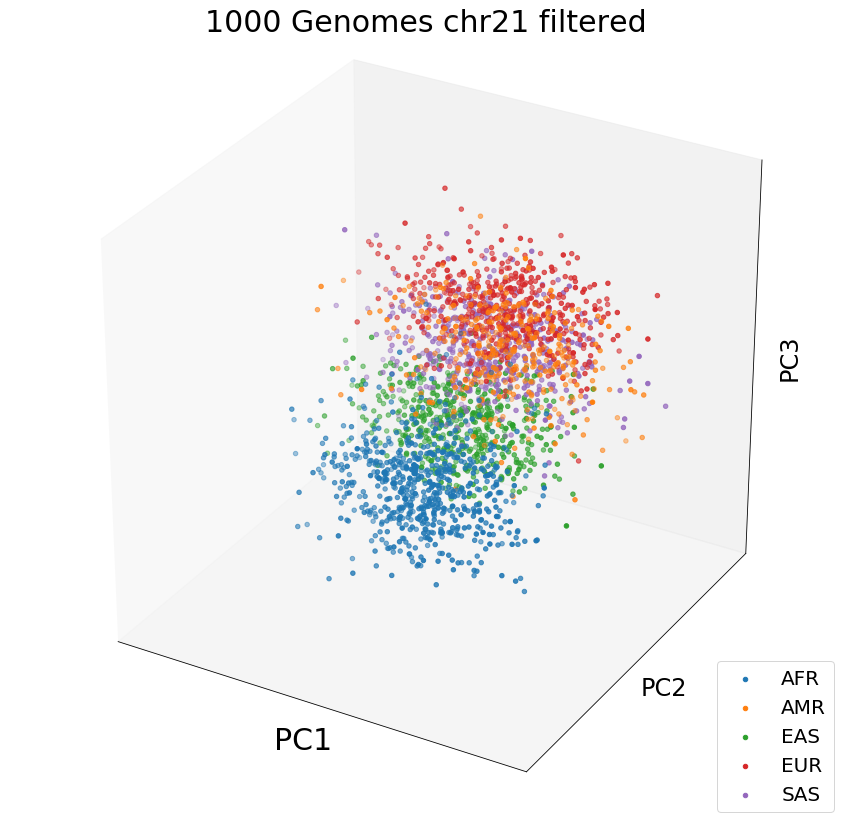

In [95]:
PlotPCA3D(ConvertedSamples, PCs, samples, "1000 Genomes chr21 filtered", "filtered_chr21_PCA.jpg")

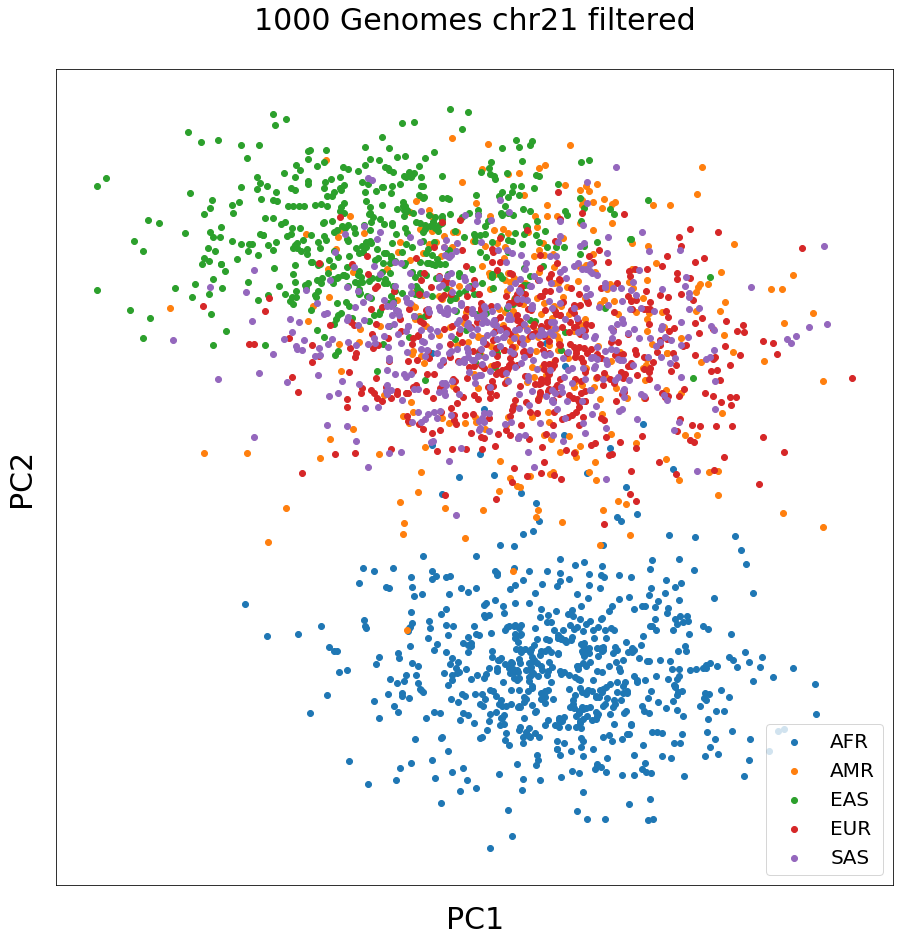

In [96]:
PlotPC122D(ConvertedSamples, PCs, samples, "1000 Genomes chr21 filtered", "filtered_chr21_PC1PC2.jpg")

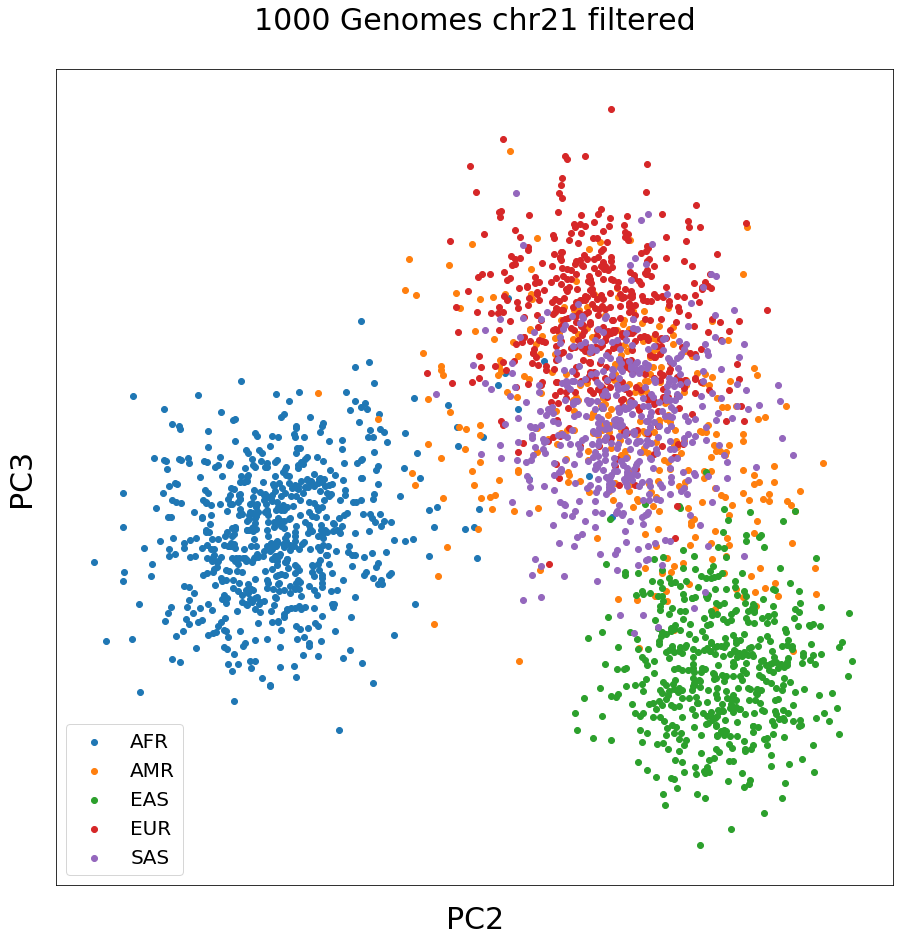

In [97]:
PlotPC232D(ConvertedSamples, PCs, samples, "1000 Genomes chr21 filtered", "filtered_chr21_PC2PC3.jpg")

Now the filtered standardized data

In [98]:
pca = PCA(n_components=3)
PCs = pca.fit_transform(StandardizedSamples)

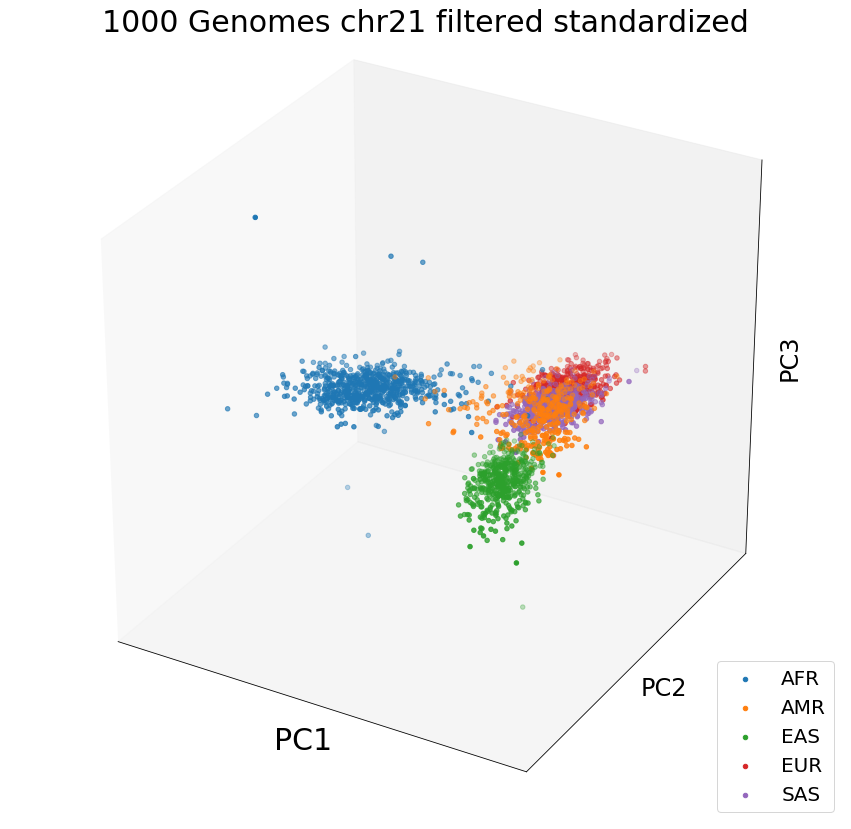

In [99]:
PlotPCA3D(StandardizedSamples, PCs, samples, "1000 Genomes chr21 filtered standardized", "filtered_standardized_chr21_PCA.jpg")

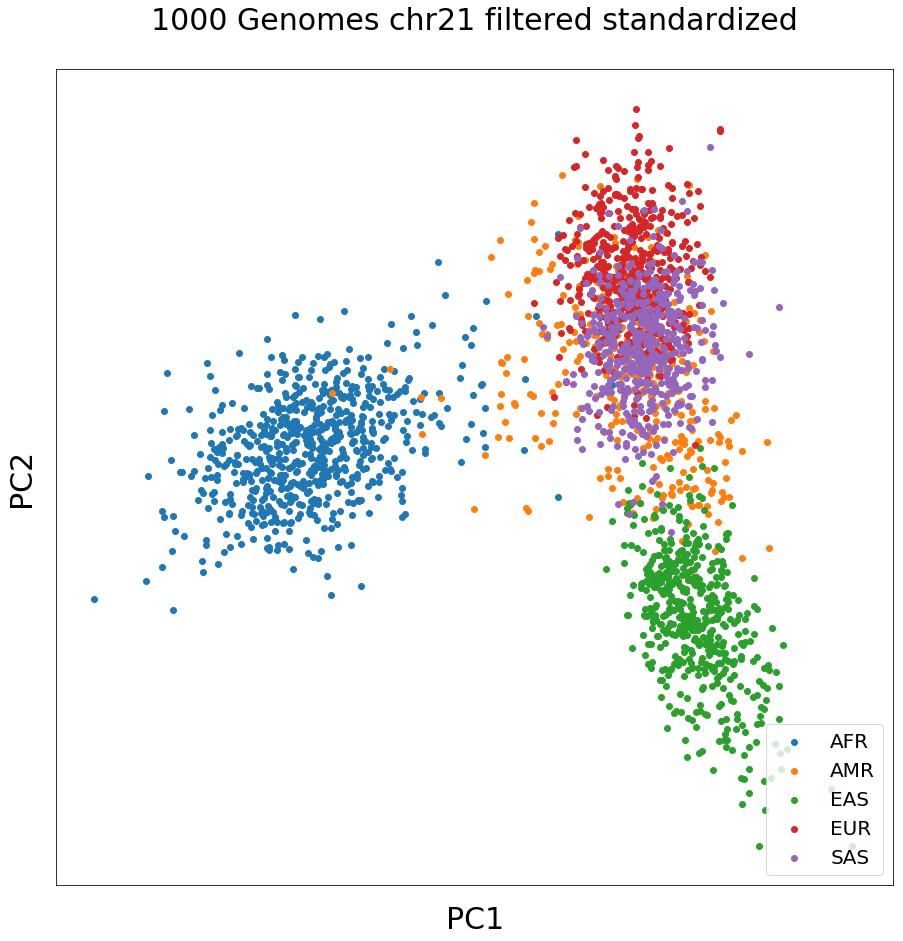

In [100]:
PlotPC122D(StandardizedSamples, PCs, samples, "1000 Genomes chr21 filtered standardized", "filtered_standardized_chr21_PC1PC2.jpg")

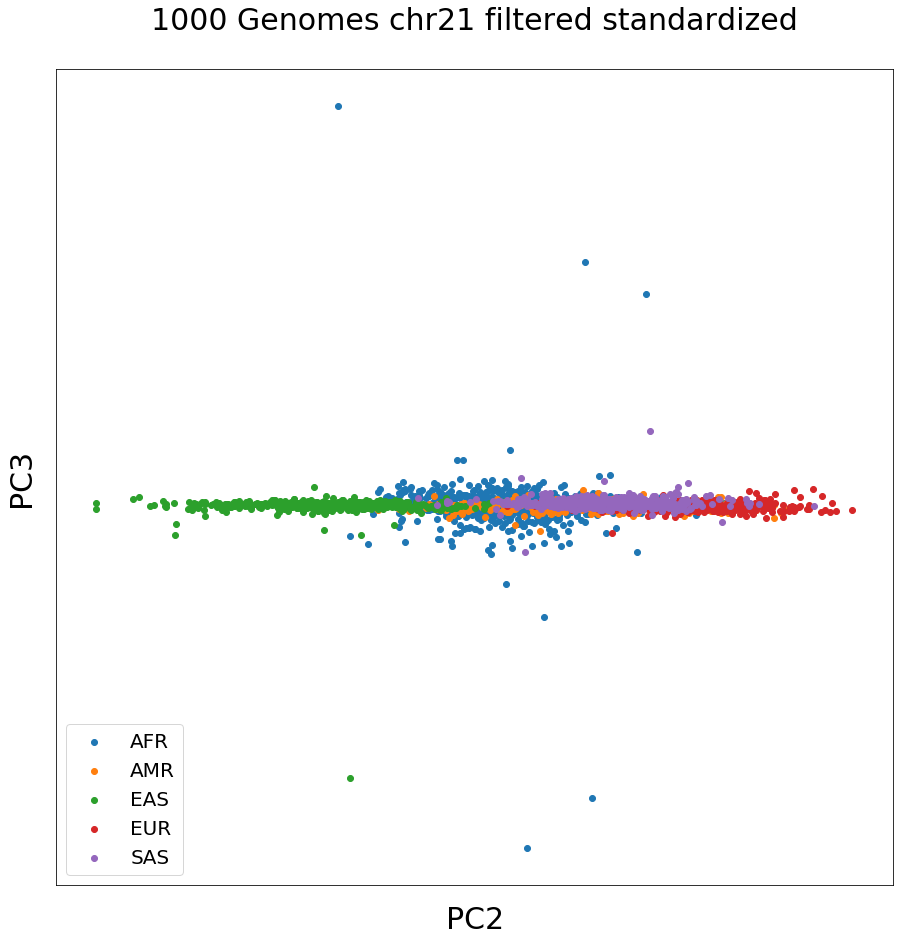

In [101]:
PlotPC232D(StandardizedSamples, PCs, samples, "1000 Genomes chr21 filtered standardized", "filtered_standardized_chr21_PC2PC3.jpg")